Title: Les séries temporelles avec Python (4/4) - Analyse et modélisation
Author: Louis
Date: '2022-11-08'
Slug: timeseries-3
Category: Python
Tags: Python, Machine Learning, Statistiques, Data Science, Séries temporelles, Datetime
Cover: images/cover_6.png
Summary: Analyse d'une série temporelle par décomposition et modélisations classiques.

[TOC]

>1. Introduction à la manipulation de données temporelles avec Python
>2. Visualisation et opérations sur les séries temporelles
>3. Éléments théoriques et exemples
>4. **Analyse, modélisation et prédiction**

Après une toute petite ellipse temporelle de plus d'un an, ce quatrième post s'attaque au vrai problème à savoir la décomposition, la modélisation et la prédiction des séries temporelles à l'aide des modèles statistiques classiques.

## Décomposition d'une série temporelle

Le principe de la décomposition des séries temporelles est de découper les séries originales en plusieurs composants indépendants (vus dans le post précédent) : tendance, saisonnalité, cycle et bruit.

Pour illustrer tout ça, on va utiliser des données qui sont aux séries temporelles ce que le dataset "Titanic" est au machine learning : la série AirPassenger qui mesure le nombre mensuel de passagers aériens, en milliers, de janvier 1949 à décembre 1960. Dans la suite, on notera $X_{t}$  la série AirPassengers et $Y_t=ln(X_t)$. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fonctions as fct

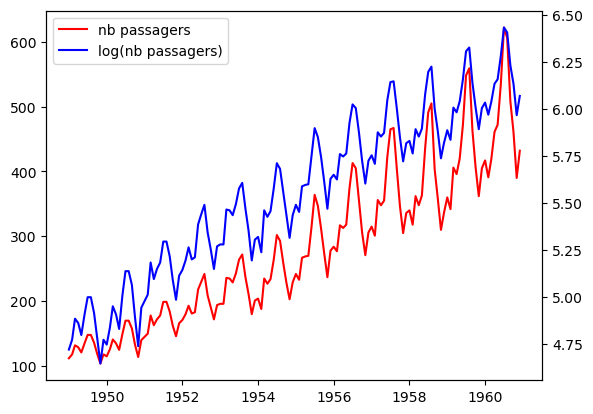

In [2]:
x = pd.read_csv('data/AirPassengers.csv', index_col=0, parse_dates=True)
y = np.log(x)

# création d'un graphique avec la série originale
fig, ax = plt.subplots()
ln1 = ax.plot(x, c='r', label="nb passagers")

# création d'un graphique avec la série log en conservent le même axe des abscisses
ax2 = ax.twinx()
ln2 = ax2.plot(y, c='b', label="log(nb passagers)")

# ajout de la légende
lns = ln1 + ln2
labels=[l.get_label() for l in lns]
ax.legend(lns, labels);

On voit sur la série initiale (en rouge) que l'amplitude des variations augmente chaque année de manière exponentielle. Or dans un cadre théorique parfait, on voudrait une variance constante au court du temps. Pour s'en approcher on peut passer par la fonction logarithme. En effet, comme $log(ab) = log(a) + log(b)$, le $log$ transforme un modèle **multiplicatif** en un modèle **additif**. Ainsi l'accroissement de l'amplitude des pics (donc de la variance) pour la série $X$ disparaît avec la transformation logarithmique. C'est visible sur la courbe bleue.  

### La tendance

On a présenté dans le premier post une façon de visualiser la tendance en lissant la courbe à l'aide des moyennes mobiles sur une fenêtre glissante d'observations. Lorsqu'on choisit différentes tailles de fenêtres glissantes, on obtient les résultats suivants.

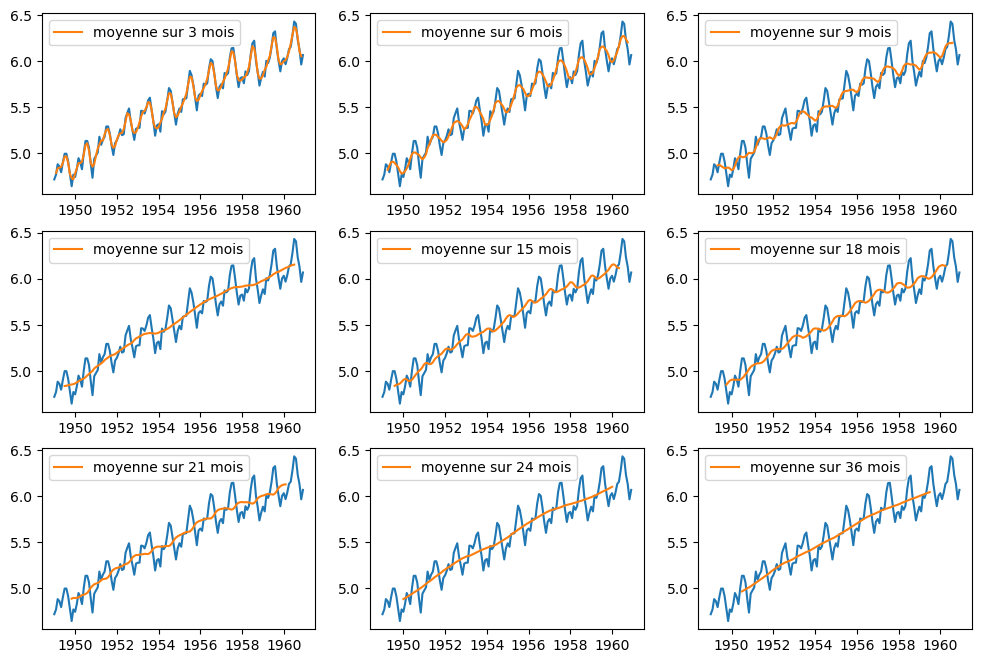

In [3]:
win = [3, 6, 9, 12, 15, 18, 21, 24, 36]
fig = plt.figure(figsize=(12,8))

for i in range(len(win)):
    ax = fig.add_subplot(3, 3, i+1)
    ax.plot(y)
    ax.plot(y.rolling(win[i], center=True).mean(), label=f"moyenne sur {win[i]} mois")
    ax.legend()

En prenant une fenêtre de 12, 24 ou 36 mois, une tendance linéaire et croissante est bien visible. Par ailleurs, le fait que cette tendance est identifiable pour des fenêtres glissantes dont la taille est un multiple de 12 mois suggère une notion de saisonnalité. On ne sait peut-être pas encore ce que c'est, mais en tout cas, il se passe quelque chose tous les 12 mois...

### La saisonnalité

La saisonnalité désigne les tendances hebdomadaires, mensuelles, trimestrielles ou annuelles. Ce sont les motifs qui se répètent sur une durée infra-annuelle. Il semble qu'on ait ici une saisonnalité annuelle. Une manière visuelle de vérifier l'effet saisonnier est de tracer une courbe pour chaque année en prenant les mois comme abscisses et visualiser ainsi la répartition des passagers au cours de chaque année.

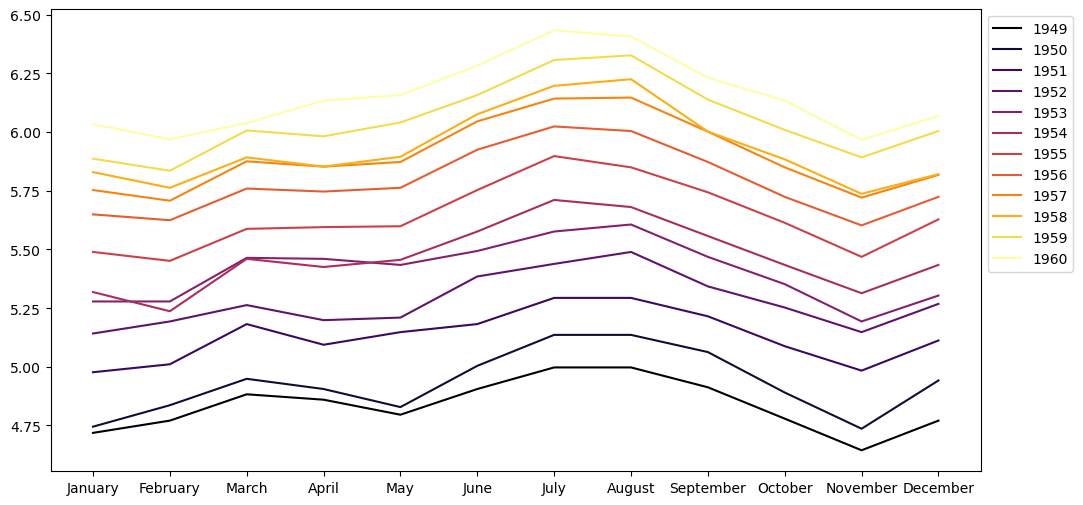

In [4]:
plt.figure(figsize=(12, 6))

yrs = [str(yr) for yr in y.index.year.unique()]
mths = y.index.month_name().unique()
colors = plt.cm.inferno(np.linspace(0,1,len(yrs)))

for i in range(len(yrs)):
    plt.plot(mths, y.loc[yrs[i]], label=yrs[i], color=colors[i])
    plt.legend(bbox_to_anchor=(1,1))

Ça confirme bien l'intuition : les variations du nombre de passagers aériens sur une année sont similaires d'une année sur l'autre. C'est la saisonnalité. Et en plus c'est joli.

### Le bruit

Il ne reste plus qu'à identifier ce qu'il reste : le bruit. On l'obtient donc en soustrayant (dans un modèle additif !) à la série originale les tendance et saisonnalité. Au final, voilà une série décomposée.

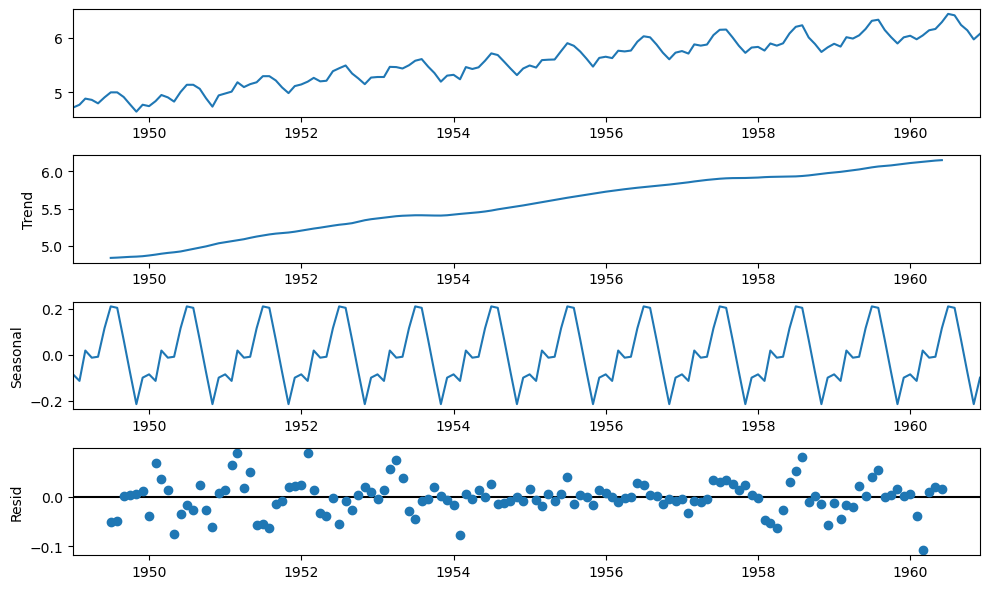

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

decomp = seasonal_decompose(y, model='additive')

fig = decomp.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

## Prévision avec un lissage exponentiel

Le lissage exponentiel est une technique de lissage pas brésilien qui ressemble un peu aux moyennes mobiles. Cette méthode peut être utilisée pour prédire une série temporelle. C'est en fait un cas particulier des modèles ARMA déjà évoqués. On en distingue différents types (simple, double, triple...). On notera que les lissages exponentiels simple et double ne sont plus vraiment d'actualité donc on présente seulement le lissage exponentiel triple qui, lui, est parfois utilisé.

Le lissage exponentiel triple ou méthode de Holt-Winters est adapté à des séries à tendance localement linéaire avec en plus une composante saisonnière. Ce qui est le cas de notre série logarithmique.

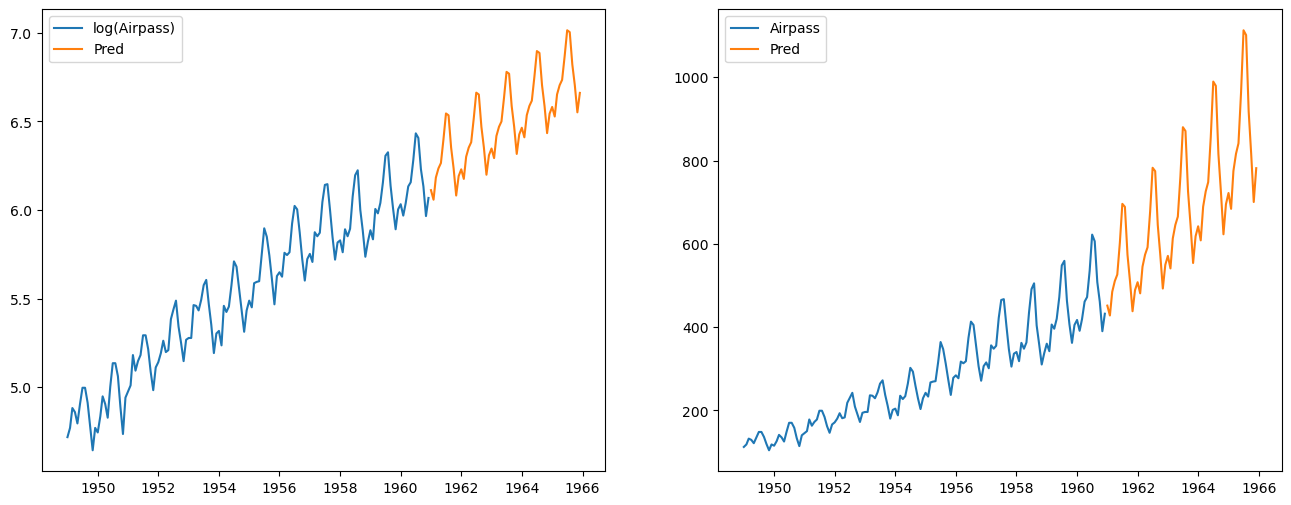

In [6]:
from statsmodels.tsa.api import ExponentialSmoothing

let = ExponentialSmoothing(y.values, seasonal_periods=12, trend='add', seasonal='add').fit()

y_pred = let.forecast(60)# prédiction pour la série log
x_pred = np.exp(let.forecast(60)) # récupération des prédiction pour la série originale

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.plot(y, label='log(Airpass)')
ax1.plot(pd.date_range(y.index[len(y)-1], periods=60, freq='M'), y_pred, label='Pred')
ax1.legend()

ax2.plot(x, label='Airpass')
ax2.plot(pd.date_range(y.index[len(y)-1], periods=60, freq='M'), x_pred, label='Pred')
ax2.legend()

plt.show()

## Prévision à l'aide d'un modèle ARIMA

Un modèle autoréfressif intégré à moyennes mobiles (ARIMA) est une généralisation du modèle ARMA, aperçu dans le post précédent. Ils sont utilisés dans certains cas où les données montrent une non-stationnarité. Une étape de différenciation initiale (correspondant à la partie "intégrée" du modèle) peut alors être appliquée une ou plusieurs fois afin d'éliminer la non-stationnarité. Dans le modèle de base, trois paramètres $(p,d,q)$ sont utilisés pour caractériser les modèles ARIMA. On les note donc $ARIMA(p,d,q)$ et ils sont définis par :
$$
\left(1 - \sum_{i=1}^p \phi_i L^i \right) (1 - L)^d y_t = \mu + \left(1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t
$$

$L$ est l'opérateur *retard* qui consiste à décaler la série d'une observation.

SARIMA, ou ARIMA saisonnier, est une généralisation du modèle ARIMA qui permet de tenir compte de la saisonnalité. Ce modèle est caractérisé non plus par 3 paramètres $(p,d,q)$ mais par 7 ! Il est noté $SARIMA(p,d,q)(P,D,Q)_s$ où :
- $s$ est la période de la saisonnalité
- $(P,D,Q)$ sont les ordres de la partie saisonnière

### Stationnarisation de la série

Les séries ont généralement une tendance et une saisonnalité toutefois afin de pouvoir les modéliser par des processus stationnaires comme les ARMA, il faut qu'elles soient stationnaires. Or elles ne le sont que rarement, il faut donc les stationnariser.

On sait que notre série n'est pas stationnaire (c'est vérifiable en regardant l'autocorrélogramme qui doit présenter une décroissance lente vers 0). Par ailleurs, on a déjà identifié la saisonnalité de nos observations qui est annuelle. On peut déjà effectuer une différenciation en appliquant l'opérateur $(1-L^{12})$ .

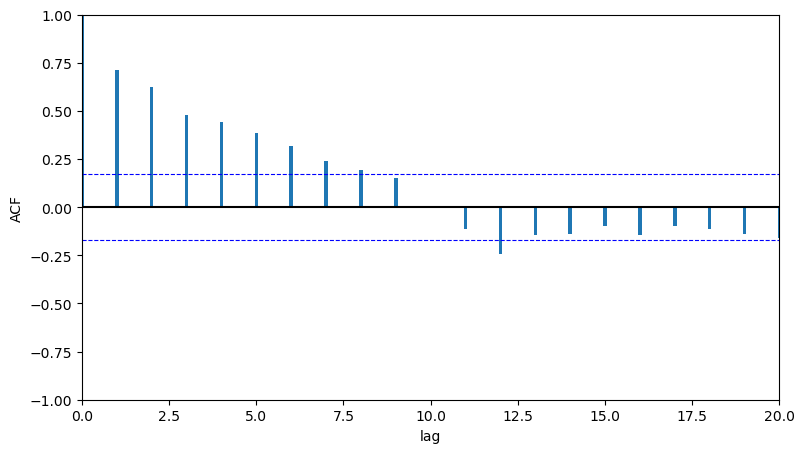

In [7]:
y_diff_12 = y - y.shift(12)
fct.plot_acf_pacf(y_diff_12[12:], fig_size=(9,5))

La sortie ACF présente bien une décroissance lente vers 0, ce qui traduit la non-stationnarité. On effectue donc une différenciation en appliquant cette fois l'opérateur $(1-L)$.

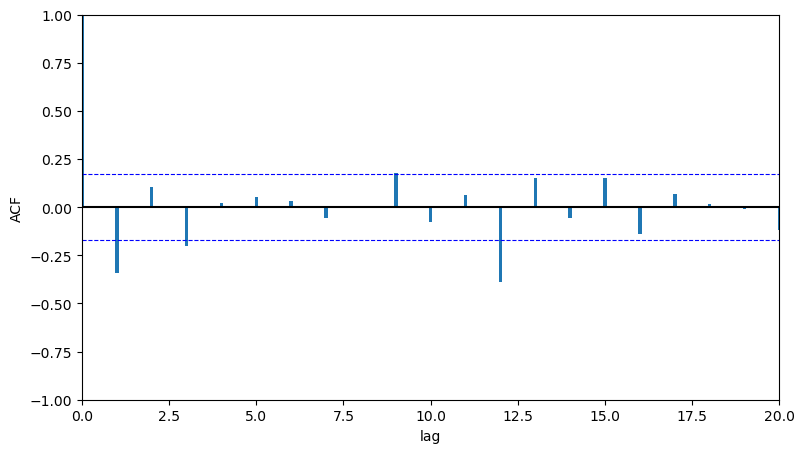

In [8]:
y_diff_12_1 = y_diff_12 - y_diff_12.shift(1)
fct.plot_acf_pacf(y_diff_12_1[13:], fig_size=(9,5))

Avec cette double différenciation, on s'approche d'un autocorrélogramme simple empirique. On va donc modéliser la série $(1-L)(1-L^{12})ln(X_t)$ par un modèle ARMA.

### Identification, estimation et validation de modèles

On va s'appuyer sur les sorties ACF et PACF donc on peut utiliser une des fonctions disponibles dans `fonctions.py`.

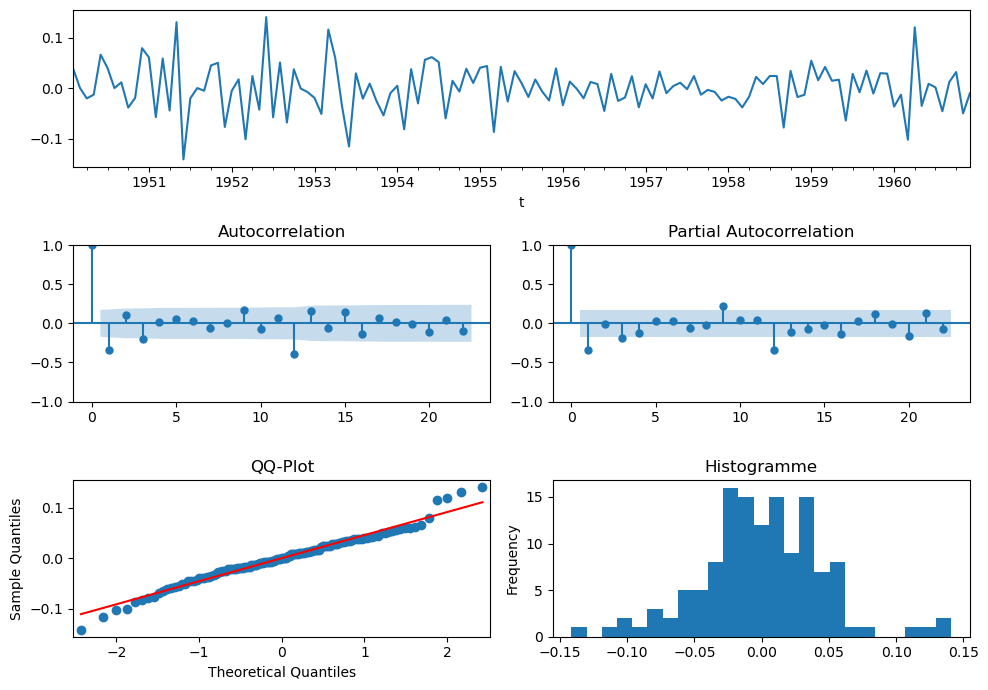

In [9]:
fct.ts_plot(y_diff_12_1[13:].Airpass, fig_size=(10,7))

Les graphiques ACF et PACF permettent de voir empiriquement qu'on va avoir un modèle $SARIMA(p,d,q)(P,D,Q)_s$ avec $s=12$.


Il est possible de trouver empiriquement un ordre de grandeur maximum pour les parties *autorégressive* et *moyenne mobile*, c'est-à-dire pour les valeurs $p_{max}$ et $q_{max}$ d'un modèle $ARMA(p,q)$. La détermination de bornes supérieures concernant l'ordre de la partie $AR$ et de la partie $MA$ passe par l'étude des autocorrélogrammes et des autocorrélogrammes partiels. En effet, si la série stationnaire suit un modèle $ARMA(p,q)$ alors :  

- l'autocorrélogramme ACF devient nul à partir du rang $q+1$  
- l'autocorrélogramme partiel PACF devient nul à partir du rang $p+1$

Le tableau suivant résume les propriétés des tracés de l'ACF et de la PACF empiriques :

|      |   MA(q)    |    AR(p)   | ARMA(p,q) |
|------|:----------:|:----------:|:----------:|
| ACF  | 0 si k > q | $\searrow$ | $\searrow$ |
| PACF | $\searrow$ | 0 si k > p | $\searrow$ |

Dès lors, en se basant sur les autocorrélogrammes, il est possible de déterminer empiriquement les ordres maximum en regardant à partir de quel rang les autocorrélogrammes sont statistiquement nuls. Dans notre cas, on peut considérer que $p_{max} = q_{max} = 1$ et on va donc tester différents modèles compte tenu de ces bornes.


**Modèle 1 :** pour commencer on modélise un $SARIMA(1,1,1)(1,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-\phi'_{1}L^{12})(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [10]:
from statsmodels.tsa.statespace.sarimax import *

m1 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(1,1,1,12))
res1 = m1.fit(disp=False)
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Wed, 09 Nov 2022   AIC                           -480.304
Time:                                    15:47:19   BIC                           -465.928
Sample:                                         0   HQIC                          -474.462
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1701      0.212      0.801      0.423      -0.246       0.586
ma.L1         -0.5649      0.184   

Ce modèle a des coefficients non significatifs, on en teste un second en retirant dans le paramètre associé à la plus grande p-value : ici c'est le terme autorégressif saisonnier.

**Modèle 2 :** on modélise donc un $SARIMA(1,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-\phi_{1}L)(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [11]:
m2 = SARIMAX(y.values, order=(1,1,1), seasonal_order=(0,1,1,12))
res2 = m2.fit(disp=False)
print(res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.945
Date:                            Wed, 09 Nov 2022   AIC                           -481.890
Time:                                    15:47:21   BIC                           -470.389
Sample:                                         0   HQIC                          -477.217
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1841      0.201      0.915      0.360      -0.210       0.578
ma.L1         -0.5667      0.174   

Ce modèle a toujours un coefficient non significatif, on en teste un 3ème modèle en retirant le terme autorégressif d'ordre 1.

**Modèle 3 :** on modélise donc un $SARIMA(0,1,1)(0,1,1)_{12}$ qui s'écrit :
$$(1-L)(1-L^{12})ln(X_{t})=(1+\theta_{1}L)(1+\theta'_{1}L^{12})\epsilon_{t} $$

In [12]:
m3 = SARIMAX(y.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res3 = m3.fit(disp=False)
print(res3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Wed, 09 Nov 2022   AIC                           -483.393
Time:                                    15:47:22   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4013      0.073     -5.496      0.000      -0.544      -0.258
ma.S.L12      -0.5566      0.096   

Cette fois tous les coefficients sont significatifs, il faut encore tester ce qu'on appelle la "blancheur" des résidus : on veut avoir des résidus qui sont un bruit blanc (faible), c'est-à-dire, entre autres qu'ils sont non corrélés.  
Pour ça on peut utiliser le test de Ljung-Box d'autocorrélation des résidus qui est implémenté dans la fonction `acorr_ljungbox` de `statsmodels.stats.diagnostic` 

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res3.resid, lags=lag, return_df=False)[1].mean()))

Retard : p-value
6 : 0.981720860200859
12 : 0.9083064612785483
18 : 0.6207396507474344
24 : 0.5187361239841579
30 : 0.5161804687133994
36 : 0.560395354197207


Toutes les p-values sont élevées ce qui signifie qu'on ne peut pas rejeter l'hypothèse nulle du test. Or, l'hypothèse $H_0$ est qu'il n'y a pas d'autocorrélation des résidus, on peut pas la rejeter, donc on est bon !

On peut enfin tester la normalité des résidus avec le test de Shapiro-Wilk implémenté dans la fonction `scipy.stats.shapiro`, l'hypothèse nulle étant que les étant que les observations sont normalement distribuées, on souhaite encore une fois une p-value élevée pour ne pas rejeter $H_0$.

In [14]:
from scipy.stats import shapiro
shapiro(res3.resid[13:])

ShapiroResult(statistic=0.9908484220504761, pvalue=0.547280490398407)

Le test de normalité est également validé pour ce modèle et on peut afficher les résidus pour le visualiser :

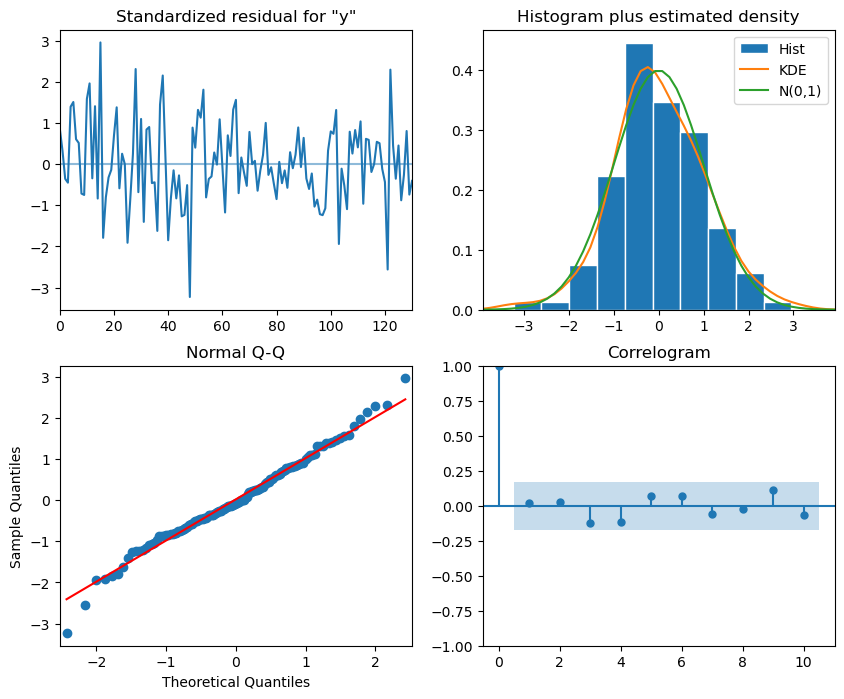

In [15]:
res3.plot_diagnostics(figsize=(10, 8));

### Prévision de l’année 1961 avec le modèle retenu

Maintenant qu'on a modélisé notre série, on peut se servir de ce modèle pour faire des prédictions avec la méthode `get_forecast()`

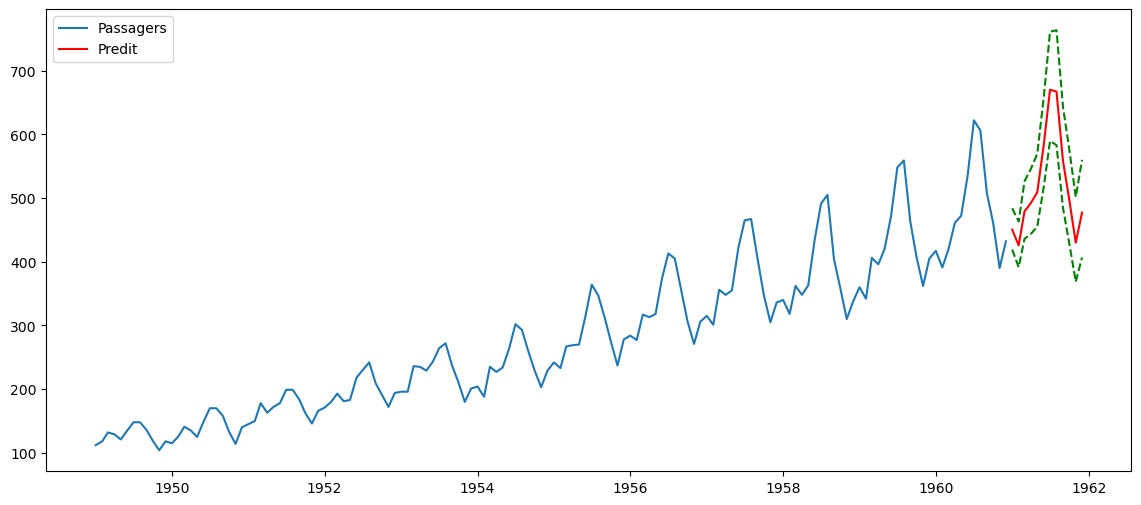

In [16]:
# prédiction et intervalles de confiance
y_pred = res3.get_forecast(12)
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# affichage
plt.figure(figsize=(14,6))
plt.plot(x.index, x.values, label='Passagers')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_inf, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[-1], periods=12, freq='M'), x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

### Évaluation de la qualité prédictive du modèle

On n'en a pas parlé jusqu'ici mais pour construire un modèle prédictif, il faut mettre en place, entraîner, tester et évaluer votre modèle. Pour cela, il est nécessaire de découper nos données en échantillons d'entraînement et de test. Pour des observations non chronologiques, on découpe de manière aléatoire mais pour des données temporelles, on est obligé de conserver la chronologie dans l'échantillon d'entraînement. Pour cela, on va tout simplement tronquer la série : les **données d'entraînement sont les observations jusqu'en 1958** et les **données de test sont celles des années 1959 et 1960**.

On va utiliser directement le modèle $SARIMA(0,1,1)(0,1,1)_{12}$ obtenu avec toutes les observations de la série. Toutefois, il est plus rigoureux de s'assurer que le modèle retenu précédemment est toujours valide sur la série tronquée `y_train`. Pour cela on regarde la significativité des coefficients, l'autocorrélation et la normalité des résidus.

Le modèle $SARIMA(0,1,1)(0,1,1)_{12}$ étant bien valide sur les données tronquées, on peut prédire les valeurs des années 1959 et 1960 et les afficher sur le graphique suivant avec les valeurs réelles, prédites et les intervalles de confiance.

Enfin, on ajoute des métriques d'erreur : RMSE et MAPE.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 197.505
Date:                            Wed, 09 Nov 2022   AIC                           -389.010
Time:                                    15:47:24   BIC                           -380.991
Sample:                                         0   HQIC                          -385.759
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3422      0.087     -3.921      0.000      -0.513      -0.171
ma.S.L12      -0.5407      0.105   

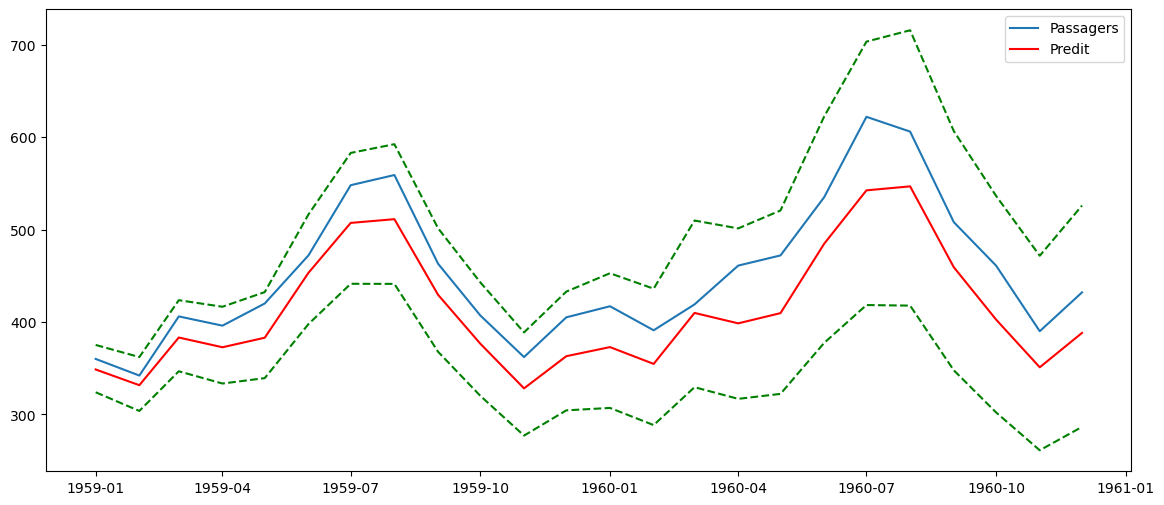

RMSE = 43.18024430485034 et MAPE = 8.51556515346472


In [17]:
# série x : série des passagers
x_train = x.loc[:'1958', 'Airpass']
x_test = x.loc['1959':, 'Airpass']
# série y=log(x) : transformation logarithmique de la série des passagers 
y_train = y.loc[:'1958', 'Airpass']
y_test = y.loc['1959':, 'Airpass']

# modélisation et summary
model = SARIMAX(y_train.values, order=(0,1,1), seasonal_order=(0,1,1,12))
res = model.fit(disp=False)
print(res.summary())

# test d'autocorrélation des résidus
print('Retard : p-value')
for lag in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(lag, acorr_ljungbox(res.resid, lags=lag, return_df=False)[1].mean()))
    
# test de normalité des résidus
print(shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_forecast(len(y_test))
x_pred = np.exp(y_pred.predicted_mean)
x_pred_inf = [np.exp(p[0]) for p in y_pred.conf_int(alpha=0.05)]
x_pred_sup = [np.exp(p[1]) for p in y_pred.conf_int(alpha=0.05)]

# graphique
plt.figure(figsize=(14,6))
plt.plot(x_test.index, x_test.values, label='Passagers')
plt.plot(x_test.index, x_pred, color='r', label='Predit')
plt.plot(x_test.index, x_pred_inf, color='g', linestyle='--')
plt.plot(x_test.index, x_pred_sup, color='g', linestyle='--')
plt.legend()
plt.show()

# métriques
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

Ainsi on obtient su les 2 années 1959 et 1960, une erreur moyenne de prédiction de 43,2 passagers (RMSE) et une erreur moyenne absolue en pourcentage de 8,5%.

### Une autre approche pour la détermination du modèle

Pour ajuster un modèle SARIMA aux données d'une série temporelle, il faut déterminer le jeu de paramètres $(p,d,q)(P,D,Q)s$ optimaux. On peut faire de la recherche sur grille qui consiste à tester de manière itérative plusieurs valeurs possibles des paramètres et d'évaluer les modèles en utilisant des critères tels que AIC ou BIC.

On utilisera nous le critère d'information Akaike ($AIC$) qui mesure la qualité relative des modèles statistiques pour un ensemble d'observations donné. À partir d'un ensemble de modèles, le critère $AIC$ permet d'estimer la qualité de chacun des modèles par rapport aux autres. Cela permet donc de sélectionner des modèles. Intuitivement, le critère $AIC$ mesure le compromis entre la qualité de l'ajustement du modèle aux observations fournies et la complexité du modèle (nombre de paramètres inclus et estimés). Le critère $AIC$ est calculé par :

$AIC=2k-2ln(L)$ avec :
- $k$ nombre de paramètres estimés
- $L$ valeur maximale de la vraisemblance (pour simplifier maximiser la vraisemblance revient plus ou moins à minimiser l'erreur)

Le meilleur modèle est celui qui minimise le critère $AIC$. À titre de comparaison, on regarde aussi selon le critère BIC.

Dans on premier temps, on va générer toutes les valeurs possibles des paramètres que nous aimerions évaluer, à savoir $(p,d,q)(P,D,Q)$ puisqu'on sait déjà que $s=12$. On testera les modèles pour toutes les combinaisons possibles pour des valeurs entre 0 et 1 pour chacun des 6 paramètres c'est-à-dire $2^6 = 64$ possibilités. Si on va jusqu'à 2 pour chaque paramêtre, on passe à $3^6 = 729$ possibilités, ce qui va commencer à faire un peu long...

In [18]:
from statsmodels.tsa.statespace.sarimax import *
from tqdm import tqdm
import itertools

import warnings
warnings.filterwarnings(action='ignore') #'once' pour afficher le warning une seule fois

# on génère toutes les combinaisons possibles des paramèters
p = d = q = P = D = Q = range(2)
params = list(itertools.product(p, d, q, P, D, Q))

# on initialise nos paramètres optimaux
tmp_model = None
best = {}
best['aic'] = {'pdq': None, 'PDQ':None, 'model':None, 'aic':np.inf, 'bic':np.inf}
best['bic'] = {'pdq': None, 'PDQ':None, 'model':None, 'aic':np.inf, 'bic':np.inf}

for p,d,q,P,D,Q in tqdm(params):
    tmp_model = SARIMAX(y_train,
                        order = (p,d,q),
                        seasonal_order = (P,D,Q,12),
                        enforce_stationarity=True,
                        enforce_invertibility=True)
    res = tmp_model.fit(disp=False)

    if res.aic < best['aic']['aic']:
        best['aic']['aic'] = res.aic
        best['aic']['bic'] = res.bic
        best['aic']['pdq'] = (p,d,q)
        best['aic']['PDQ'] = (P,D,Q)
        best['aic']['model'] = res
    
    if res.bic < best['bic']['bic']:
        best['bic']['aic'] = res.aic
        best['bic']['bic'] = res.bic
        best['bic']['pdq'] = (p,d,q)
        best['bic']['PDQ'] = (P,D,Q)
        best['bic']['model'] = res

print(f"Modèle retenu selon le critère AIC : SARIMA{best['aic']['pdq']}{best['aic']['PDQ']}12 - AIC:{best['aic']['aic']} - BIC:{best['aic']['bic']}")
print(f"Modèle retenu selon le critère BIC : SARIMA{best['bic']['pdq']}{best['bic']['PDQ']}12 - AIC:{best['bic']['aic']} - BIC:{best['bic']['bic']}")

100%|███████████████████████████████████████████| 64/64 [00:59<00:00,  1.08it/s]

Modèle retenu selon le critère AIC : SARIMA(0, 1, 1)(1, 0, 1)12 - AIC:-405.4220890824692 - BIC:-394.3055951100231
Modèle retenu selon le critère BIC : SARIMA(0, 1, 1)(1, 0, 1)12 - AIC:-405.4220890824692 - BIC:-394.3055951100231


Le meilleur modèle selon le critère AIC est le $SARIMA(0,1,1)(1,0,1)_{12}$ qui diffère légèrement de celui obtenu avec la méthode précédente. Il convient de noter cependant que le modèle précédent $SARIMA(0,1,1)(0,1,1)_{12}$ a été obtenu sur toutes les observations.

Passons à la prédiction pour terminer.

                                     SARIMAX Results                                      
Dep. Variable:                            Airpass   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 206.711
Date:                            Wed, 09 Nov 2022   AIC                           -405.422
Time:                                    15:48:24   BIC                           -394.306
Sample:                                01-01-1949   HQIC                          -400.908
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2909      0.082     -3.544      0.000      -0.452      -0.130
ar.S.L12       0.9888      0.009   

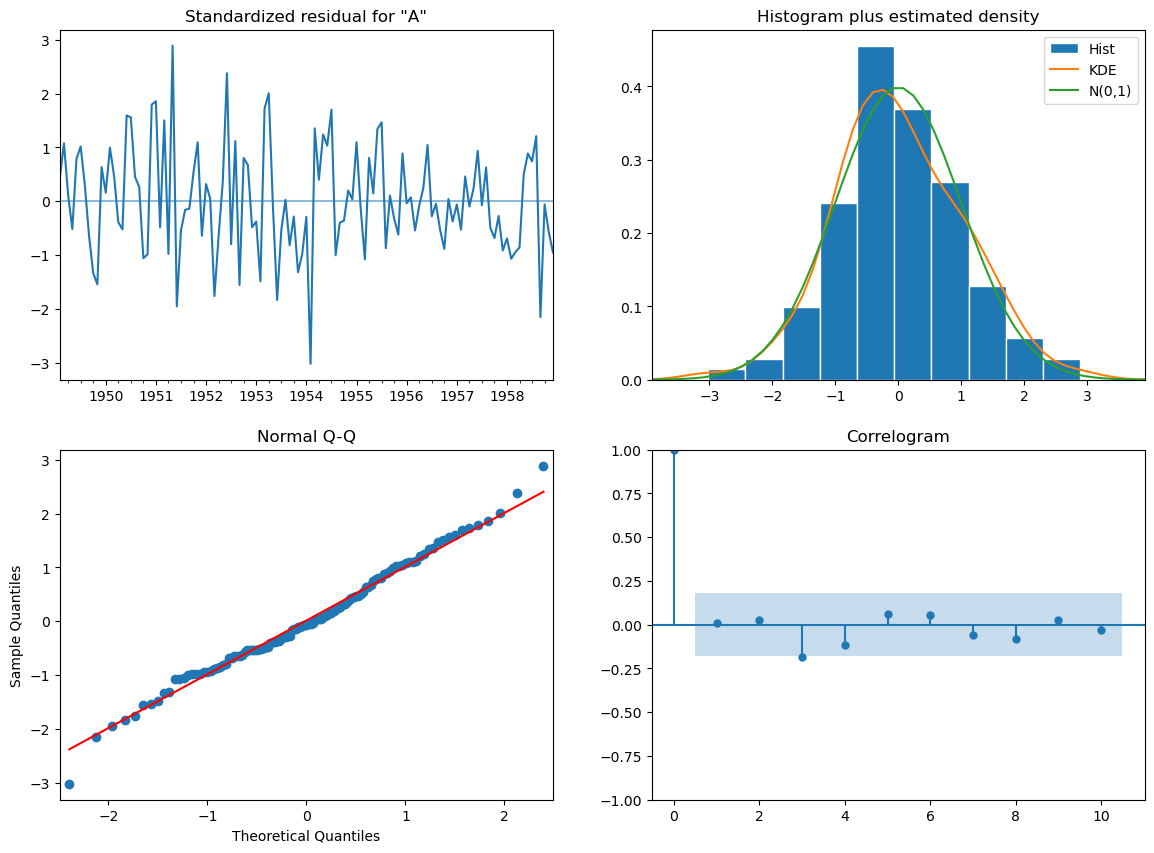

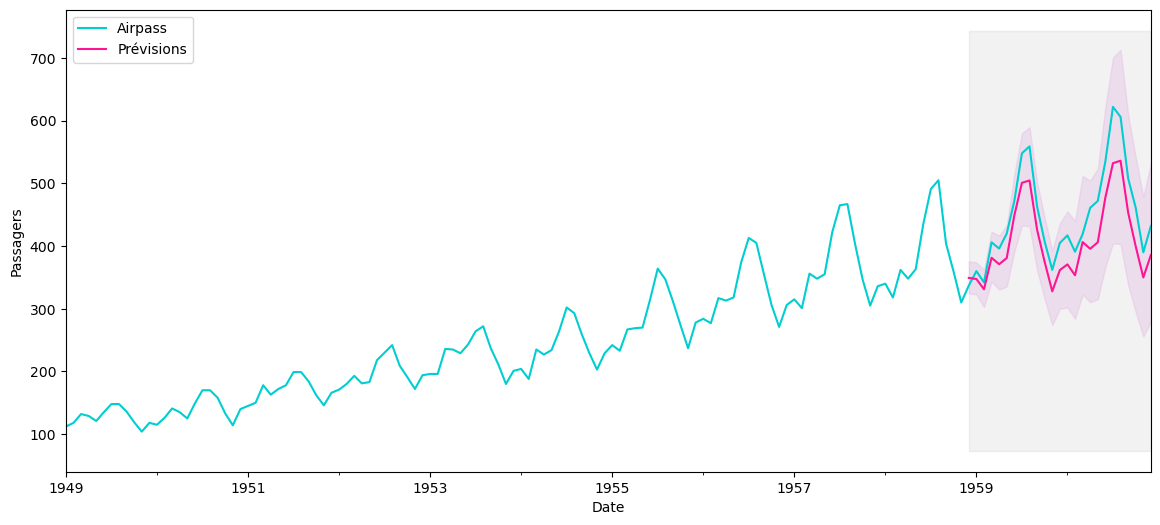

RMSE = 47.11786986382567 et MAPE = 9.220540274482799


In [19]:
# modèle retenu
res = best['aic']['model']

# summary
print(res.summary())

# résidus
res.plot_diagnostics(figsize=(14, 10));
print("Test de Shapiro :", shapiro(res.resid[13:]))

# prédiction et intervalles de confiance
y_pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), end=pd.to_datetime('1960-12-01'))
x_pred = np.exp(y_pred.predicted_mean)
pred_CI = np.exp(y_pred.conf_int())

# affichage
ax = x['1949':].plot(label='Série observée', color='darkturquoise', figsize=(14,6))
x_pred.plot(ax=ax, label='Prévisions', color='deeppink')

# affichage de l'intervalle de confiance
ax.fill_between(pred_CI.index,
                pred_CI.iloc[:, 0],
                pred_CI.iloc[:, 1], color='plum', alpha=.25)

# un peu de style
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), x.index[-1], alpha=.1, zorder=-1, color='grey')
ax.set_xlabel('Date')
ax.set_ylabel('Passagers')
plt.legend(loc='upper left')
plt.show()

# métriques
rmse = np.sqrt(((x_test-x_pred)**2).mean())
mape = (np.abs(1-x_pred/x_test)).mean()*100
print("RMSE = {} et MAPE = {}".format(rmse, mape))

Le RMSE et le MAPE sont légèrement plus élevés qu'avec le précédent modèle mais restent dans les mêmes ordres de grandeur. On notera donc que dans ce cas précis, l'approche par critère d'information ne permet pas d'avoir les meilleurs résultats de prédiction sur les années 1959 et 1960. Toutefois l'approche étant plus exhaustive puisqu'on compare un grand nombre de modèle, elle mérite d'être conservée. Cette réflexion entre dans le cadre de la sélection de modèles si vous voulez en savoir plus.

## Pour aller plus loin

On va s'arrêter là pour cet article qui est déjà bien assez long mais si vous souhaitez creuser un peu sur les séries temporelles, voici quelques pistes de recherche :
- la **cointégration** : lorsqu'une relation de long terme semble exister entre deux séries
> *On parle de cointégration lorsque les deux séries sont intégrées d’ordre 1 (c'est-à-dire que la série $x_t-x_{t-1}$ est stationnaire) et qu'il existe une relation linéaire entre les deux qui soit non intégrée (ou encore intégrée d'ordre zéro ou stationnaire, tout ça c'est à peu près pareil)*
- le **modèle à correction d'erreur** et la notion associée de vitesse d'ajustement
- d'autres modèles adaptés adaptés aux séries temporelles : **Prophet** ou encore les réseaux de neurones réccurents avec notamment les **LSTM**. Tiens tiens, mais ce serait pas une bonne idée pour un petit "Bonus Series Temp" ? Allez d'accord !